# Group patients

## Load imports

In [1]:
import pandas as pd
import numpy as np
import yaml
import pickle
import copy

from dataclasses import dataclass
from sklearn.model_selection import train_test_split

import stroke_utilities.process_data as process_data

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Set up paths and filenames

In [2]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './stroke_utilities/data/'
    data_read_filename: str = 'reformatted_data_thrombolysis_decision.csv'
    data_test_filename: str = 'cohort_10000_test.csv'
    data_save_path: str = './stroke_utilities/data'
    model_folder = './stroke_utilities/models'
    notebook: str = ''

paths = Paths()

# Load data



In [3]:
with open(f'{paths.model_folder}/model.p', 'rb') as fp:
    model = pickle.load(fp)

In [4]:
test = 1

if test == 1:
    filename = paths.data_read_path + paths.data_test_filename
    test = pd.read_csv(filename)

    X_test, y_test = process_data.split_X_and_y(test, 'thrombolysis')
    
    data = process_data.one_hot_encode_column(
        X_test, 'stroke_team_id', prefix='team')
    data = data.drop('year', axis=1)

else:
    filename = paths.data_read_path + paths.data_read_filename
    data = pd.read_csv(filename)
    
    
    # Ensure all values are float and shuffle
    
    data = data.sample(frac=1.0, random_state=42)
    
    ## Limit to scan with enough time for thrombolysis
    
    with open('./stroke_utilities/fixed_params.yml') as f:
        fixed_params = yaml.safe_load(f)
    
    # allowed_onset_to_needle_time_mins = fixed_params['allowed_onset_to_needle_time_mins']
    # minutes_left = fixed_params['minutes_left']
    allowed_onset_to_scan_time = fixed_params['allowed_onset_to_scan_time']
    
    def restrict_to_onset_to_scan_on_time(big_data):    
        # Time left after scan for thrombolysis
        big_data['onset_to_scan_time'] = (
            big_data['onset_to_arrival_time'] + 
            big_data['arrival_to_scan_time']
            )
    
        mask_to_include = big_data['onset_to_scan_time'] <= allowed_onset_to_scan_time
    
        # Restrict the data to these patients:
        big_data = big_data[mask_to_include]
        return big_data
    
    data = restrict_to_onset_to_scan_on_time(data)
    
    # mask = data['onset_to_arrival_time'] <= 240
    # data = data[mask]
    
    ## Limit to 10 features and thrombolysis label
    
    features_to_use = [
        'stroke_team_id',
        'stroke_severity',
        'prior_disability',
        'age',
        'infarction',
        'onset_to_arrival_time',
        'precise_onset_known',
        'onset_during_sleep',
        'arrival_to_scan_time',
        'afib_anticoagulant',
        'year',    
        'thrombolysis'
    ]
    
    data = data[features_to_use]

## Group patients

In [5]:
masks_severity = [
    (data['stroke_severity'] < 8),
    ((data['stroke_severity'] >= 8) & (data['stroke_severity'] <= 32)),
    (data['stroke_severity'] > 32)
    ]
masks_mrs = [
    ((data['prior_disability'] == 0) | (data['prior_disability'] == 1)),
    ((data['prior_disability'] == 2) | (data['prior_disability'] == 3)),
    ((data['prior_disability'] == 4) | (data['prior_disability'] == 5)),
    ]
masks_age = [
    (data['age'] < 80),
    (data['age'] >= 80)
    ]
masks_infarction = [
    (data['infarction'] == 0),
    (data['infarction'] != 0)
    ]
masks_onset_scan = [
    (data['onset_to_arrival_time'] + data['arrival_to_scan_time'] <= 4*60),
    (data['onset_to_arrival_time'] + data['arrival_to_scan_time'] > 4*60)
    ]
masks_precise = [
    (data['precise_onset_known'] == 0),
    (data['precise_onset_known'] != 0)
    ]
masks_sleep = [
    (data['onset_during_sleep'] == 0),
    (data['onset_during_sleep'] != 0)
    ]
masks_anticoag = [
    (data['afib_anticoagulant'] == 0),
    (data['afib_anticoagulant'] != 0)
    ]

masks = {
    'onset_scan':masks_onset_scan,
    'severity':masks_severity,
    'mrs':masks_mrs,
    'age':masks_age,
    'infarction':masks_infarction,
    'precise':masks_precise,
    'sleep':masks_sleep,
    'anticoag':masks_anticoag
}

masks_names = list(masks.keys())
masks_lists = list(masks.values())

In [6]:
# This could be shorter but it works for now:
inds_lists = []

for a in range(len(masks_lists[0])):
    for b in range(len(masks_lists[1])):
        for c in range(len(masks_lists[2])):
            for d in range(len(masks_lists[3])):
                for e in range(len(masks_lists[4])):
                    for f in range(len(masks_lists[5])):
                        for g in range(len(masks_lists[6])):
                            for h in range(len(masks_lists[7])):
                                inds_lists.append([a, b, c, d, e, f, g, h])

In [28]:
df_mask_numbers = pd.DataFrame(inds_lists, columns=[m + '_mask_number' for m in masks_names])

df_mask_numbers['mask_number'] = np.arange(len(df_mask_numbers))

df_mask_numbers

,onset_scan_mask_number,severity_mask_number,mrs_mask_number,age_mask_number,infarction_mask_number,precise_mask_number,sleep_mask_number,anticoag_mask_number,mask_number
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,1,0,2
3,0,0,0,0,0,0,1,1,3
4,0,0,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...
571,1,2,2,1,1,0,1,1,571
572,1,2,2,1,1,1,0,0,572
573,1,2,2,1,1,1,0,1,573
574,1,2,2,1,1,1,1,0,574


In [31]:
df_mask_numbers.to_csv('./uncertainty/mask_numbers.csv', index=False)

In [7]:
group_masks = []

for inds in inds_lists:
    # Patient assigned 1 if all masks are 1, else 0 (using np.product to multiply masks).
    group_masks.append(np.product([masks_lists[m][i] for m, i in enumerate(inds)], axis=0))

In [11]:
all = 1 

if all > 0:
    probs = np.round(model.predict_proba(data)[:,1], 2)

    arr = np.stack([probs, np.array(y_test)], axis=-1)
    # This is stupid but does ensure that the dataframe keeps
    # only two decimal places.
    arr = np.round(arr, 2)

    df_all_probs = pd.DataFrame(
        arr,
        columns=['Probabilities', 'Thrombolysis_real']
        )

    df_all_probs.to_csv('./uncertainty/all_probabilities.csv', index=False)

In [15]:
results_arr = np.full((3, len(data)), 0.0)

for i, g in enumerate(group_masks):
    print(i, end='\r')
    # How many patients are in this group?
    c = len(g[g == True])

    patients_inds = np.arange(len(data))[g == True]

    patients_here = data[g == True]
    y_here = y_test[g == True].values
    if len(patients_here) > 0:
        # What are their predicted probabilities?
        probs = np.round(model.predict_proba(patients_here)[:,1], 2)
    else:
        probs = np.array([])

    # results_group = [i]
    # results_group += inds_lists[i]
    results_arr[0, patients_inds] = i
    results_arr[1, patients_inds] = probs
    results_arr[2, patients_inds] = y_here
    # results_group += [probs]
    # results_group += [y_here]
    
    # results_group = np.append(np.array(copy.copy(inds_lists[i]), dtype=object), probs)
   
    # results_arr.append(results_group)

# results_arr = np.array(results_arr, dtype=object)

In [16]:
len(data)

10000

In [17]:
results_arr

array([[1.30000000e+01, 6.10000000e+01, 1.08000000e+02, ...,
        2.70000000e+01, 2.80000000e+01, 2.50000000e+01],
       [1.89999998e-01, 1.40000001e-01, 8.89999986e-01, ...,
        9.99999978e-03, 1.99999996e-02, 2.50000000e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [20]:
df_groups_probs = pd.DataFrame(
    results_arr.T,
    columns=['mask_number', 'predicted_probs', 'thrombolysis']
)

df_groups_probs

,mask_number,predicted_probs,thrombolysis
0,13.0,0.19,0.0
1,61.0,0.14,0.0
2,108.0,0.89,1.0
3,125.0,0.03,1.0
4,132.0,0.00,0.0
...,...,...,...
9995,12.0,0.41,1.0
9996,108.0,0.70,0.0
9997,27.0,0.01,0.0
9998,28.0,0.02,0.0


In [21]:
df_groups_probs.to_csv('./uncertainty/masks_probabilities.csv', index=False)

In [121]:
print(len(group_masks))

576


In [122]:
count_empty = 0
count_all = 0
low_count_inds = []

for i, g in enumerate(group_masks):
    c = len(g[g == True])
    print(c)
    count_all += c
    if c == 0:
        count_empty += 1
    elif c < 10 :
        low_count_inds.append(inds_lists[i])

45
36
1
4
133
79
0
0
443
244
71
46
1359
677
0
0
17
17
2
4
28
32
0
0
179
126
24
25
359
263
0
0
5
7
0
2
11
10
0
0
72
46
8
9
134
96
0
0
10
8
0
1
8
14
0
0
106
76
11
6
170
133
0
0
1
0
0
0
2
1
0
0
15
10
2
2
13
23
0
0
5
4
0
0
3
5
0
0
33
23
3
2
50
31
0
0
80
54
4
3
172
112
0
0
203
117
32
23
662
395
0
0
33
32
2
0
73
67
0
0
126
86
12
8
333
254
0
0
14
8
2
2
27
17
0
0
60
42
7
3
89
84
0
0
28
36
3
1
35
47
0
0
127
86
10
7
201
141
0
0
7
6
1
0
7
5
0
0
25
16
4
0
32
18
0
0
14
14
1
1
16
16
0
0
98
46
7
2
121
76
0
0
8
4
2
0
19
5
0
0
5
3
1
0
4
2
0
0
2
6
0
1
3
4
0
0
0
1
0
0
2
2
0
0
3
0
0
0
1
2
0
0
0
0
0
0
0
0
0
0
3
0
0
0
4
2
0
0
2
2
1
0
2
0
0
0
2
4
0
0
1
0
0
0
1
1
0
1
1
0
0
0
3
1
0
1
1
2
0
0
3
2
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [123]:
print(count_all)
print(count_empty)

10000
399


In [124]:
low_count_inds

[[0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 1],
 [0, 0, 0, 1, 0, 0, 1, 0],
 [0, 0, 0, 1, 0, 0, 1, 1],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 1, 1],
 [0, 0, 1, 0, 1, 0, 1, 0],
 [0, 0, 1, 0, 1, 0, 1, 1],
 [0, 0, 1, 1, 0, 0, 0, 1],
 [0, 0, 1, 1, 0, 0, 1, 1],
 [0, 0, 1, 1, 0, 1, 0, 0],
 [0, 0, 1, 1, 1, 0, 1, 1],
 [0, 0, 2, 0, 0, 0, 0, 0],
 [0, 0, 2, 0, 0, 1, 0, 0],
 [0, 0, 2, 0, 0, 1, 0, 1],
 [0, 0, 2, 0, 1, 0, 1, 0],
 [0, 0, 2, 0, 1, 0, 1, 1],
 [0, 0, 2, 1, 0, 0, 0, 0],
 [0, 0, 2, 1, 0, 0, 0, 1],
 [0, 0, 2, 1, 0, 1, 0, 0],
 [0, 0, 2, 1, 0, 1, 0, 1],
 [0, 0, 2, 1, 1, 0, 1, 0],
 [0, 0, 2, 1, 1, 0, 1, 1],
 [0, 1, 0, 0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 1, 1],
 [0, 1, 0, 1, 0, 0, 1, 0],
 [0, 1, 0, 1, 1, 0, 1, 1],
 [0, 1, 1, 0, 0, 0, 0, 1],
 [0, 1, 1, 0, 0, 0, 1, 0],
 [0, 1, 1, 0, 0, 0, 1, 1],
 [0, 1, 1, 0, 1, 0, 1, 0],
 [0, 1, 1, 0, 1, 0, 1, 1],
 [0, 1, 1, 1, 0, 0, 1, 0],
 [0, 1, 1, 1, 0, 0, 1, 1],
 [0, 1, 1, 1, 1, 0, 1, 1],
 [0, 1, 2, 0, 0, 0, 0, 0],
 

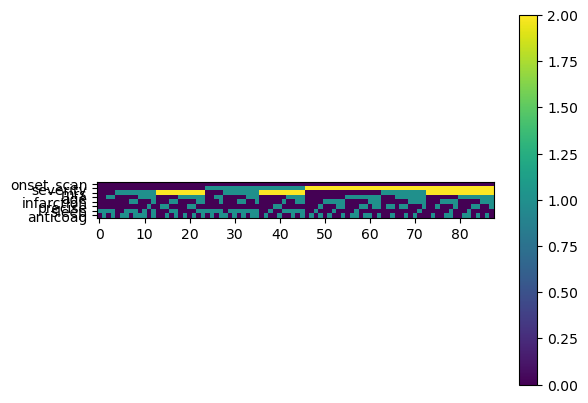

In [126]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
c = ax.imshow(np.array(low_count_inds).T)
ax.set_yticks(range(len(masks_names)))
ax.set_yticklabels(masks_names)#, rotation=90)
plt.colorbar(c)

In [127]:
lci = (np.array(low_count_inds) > 0) * np.full(np.array(low_count_inds).shape, 1)

In [128]:
lci

array([[0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 1],
       [0, 0, 1, 1, 0, 0, 0, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 0, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 1],
       [0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 1],
       [0, 0, 1, 1, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 0, 1],
       [0, 0, 1, 1, 1, 0, 1, 0],
       [0, 0, 1, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 1, 0, 1, 1],
       [0, 1, 1, 0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0, 0, 1, 0],
       [0,

In [129]:
np.sum(lci, axis=0)

array([ 0, 64, 63, 44, 33, 24, 36, 43])